# assess result sensitivity to how i've decided to split up the water masses

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import cmocean as cm
import gsw

# from cartopy import crs, feature
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# for ellipse
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import chi2, mode
from scipy.spatial.distance import mahalanobis

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('./filtered_obs.csv')

In [3]:
# can't believe you haven't made a density column yet 
CT = gsw.CT_from_t(obs['salinity (g kg-1)'],obs['temperature (degC)'],obs['pressure (dbar)'])
rho = gsw.rho_alpha_beta(np.array(obs['salinity (g kg-1)']), CT, np.array(obs['pressure (dbar)']))[0]
obs['density (kg m-3)'] = rho

In [4]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so split into summer and winter datasets before we do this
# in the future i would like to split this data up based on the actual timing of upwelling and downwelling, but for now lets just do this simple separation 

wob = obs[(obs.month >=11) | (obs.month <=2)]
sob = obs[(obs.month >= 5) & (obs.month <=8)]

In [5]:
########################
# TS DIAGRAM FUNCTIONS #
########################

# I want to add lines of constant spice
smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

def TS(df,region,ax, x, y):
    smin, smax = 28.2,36.6
    tmin, tmax = np.min(df[y]), np.max(df[y])

    salt = df[x][df.region == region].reset_index(drop=True)
    temp = df[y][df.region == region].reset_index(drop=True)

    bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
    data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]    
    ax.scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)

    title = region + "\n n= " + str(len(salt))
    ax.set_title(title)
    ax.set_ylabel(y)
    ax.set_xlabel(x)

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    if y == 'temperature (degC)' and x == 'salinity (g kg-1)':
        # density
        CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
        ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def TS_depth(df,region,ax):
    smin, smax = 28.2,36.6
    tmin, tmax = 1,19.6

    salt = df['salinity (g kg-1)'][df.region == region].reset_index(drop=True)
    temp = df['temperature (degC)'][df.region == region].reset_index(drop=True)
    z = df['depth (m)'][df.region == region].reset_index(drop=True)

    # Sort the points by depth, so that the deepest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]
                    
    sc = ax.scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label('Depth [m]', labelpad=10, fontsize=14)
    
    ax.set_title(region)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Salinity')

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    # density
    CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def xy_depth(df,region,ax):

    ax.set_extent(xlim + ylim)
    ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

    lon = df['longitude (degrees_east)'][(df.region == region)].reset_index(drop=True)
    lat = df['latitude (degrees_north)'][(df.region == region)].reset_index(drop=True)
    z = df['depth (m)'][(df.region == region)].reset_index(drop=True)
    idx = z.argsort()
    lon, lat, z = lon[idx], lat[idx], z[idx]

    ax.scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
    ax.set_title(region)

In [6]:
############
# ELLIPSES #
############

def percentile_ellipse(x, y, percentile=90, **kwargs):
    """
    Create a plot of an ellipse that covers a certain percentage of the data points,
    where the rotation and center are calculated based on the subset of data within the desired percentile.
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    # Stack x and y together for easier distance calculations
    data = np.column_stack([x_valid, y_valid])

    # Calculate the mean and covariance matrix of the full data
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_covmat = np.linalg.inv(cov)

    # Calculate the Mahalanobis distance for each point
    distances = np.array([mahalanobis(point, mean, inv_covmat) for point in data])

    # Get the distance cutoff for the given percentile
    cutoff_distance = np.percentile(distances, percentile)

    # Select the subset of points within the desired percentile
    subset_mask = distances <= cutoff_distance
    subset_data = data[subset_mask]

    # Calculate the mean and covariance for the subset of data
    subset_mean = np.mean(subset_data, axis=0)
    subset_cov = np.cov(subset_data, rowvar=False)

    # Eigenvalues and eigenvectors for scaling the ellipse
    eigvals, eigvecs = np.linalg.eigh(subset_cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The lengths of the ellipse axes
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(0.9, df=2))  # Adjust the scaling factor here

    # Angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Create the ellipse
    ellipse = Ellipse((subset_mean[0], subset_mean[1]),
                      width=width, height=height,
                      angle=angle, **kwargs)

    # # Add the ellipse to the plot
    # ax.add_patch(ellipse)
    return ellipse
    

In [7]:
# SUMMER DIVISIONS

# all water masses are important in the summer (according to Lagrangian analysis) which complicates separation a bit

# CUC = slope water south of 50.5 & salinity greater than or equal to 33.8 (need to do sensitivity analysis on this salinity choice)
# north shelf = shelf water north of 49, slope water north of 49 in the top 200 m 
# south shelf = shelf water south of 47.3, slope was south of 47.3 with salinity less than 33.8
# brackish = salinity less than or equal to 32
# offshore = offshore of 2000 m contour
# south_ul = sob[((sob.location == 'shelf') & (sob['latitude (degrees_north)'] <= 47.3)) | ((sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5) & (sob['salinity (g kg-1)'] < 33.7-0.2))]

sob['region'] = 'none'
sob.region[sob.location == 'offshore'] = 'offshore'
sob.region[(sob.location == 'shelf') & (sob['latitude (degrees_north)'] >= 49)] = 'north'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] >= 49) & (sob['depth (m)'] <= 200)] = 'north'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 50.5) & (sob['salinity (g kg-1)'] >= 33.7)] = 'cuc'
sob.region[sob['salinity (g kg-1)'] <= 31.5] = 'brackish' # putting this one last will remove the <32 points from the other regions
sob.region[((sob.location == 'shelf') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5)) | ((sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5) & (sob['salinity (g kg-1)'] < 33.7))] = 'south'


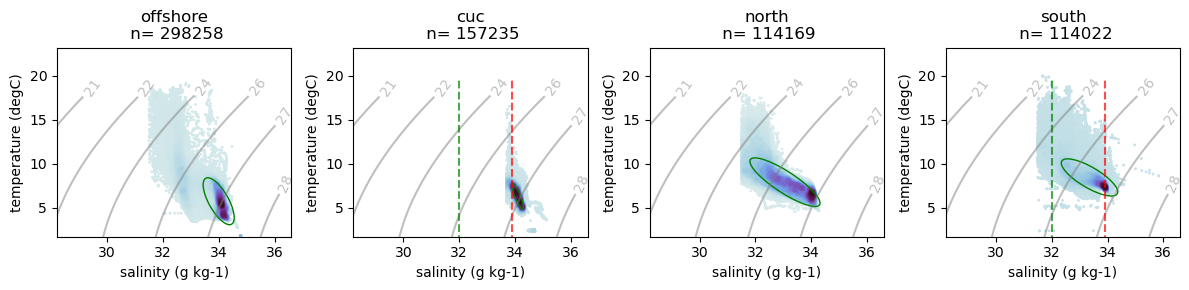

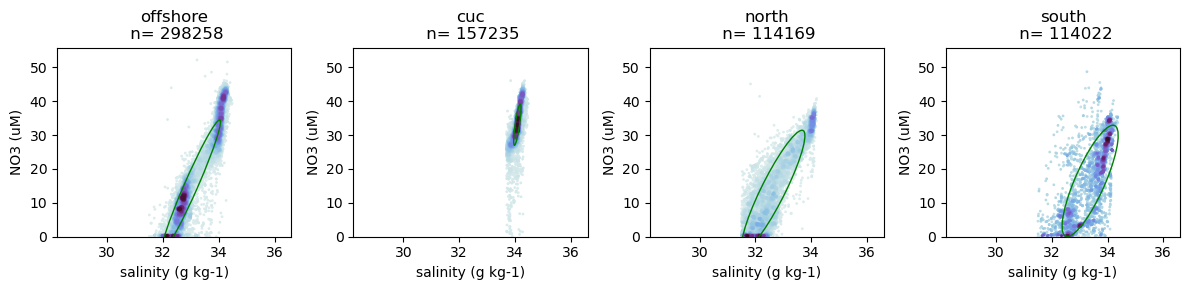

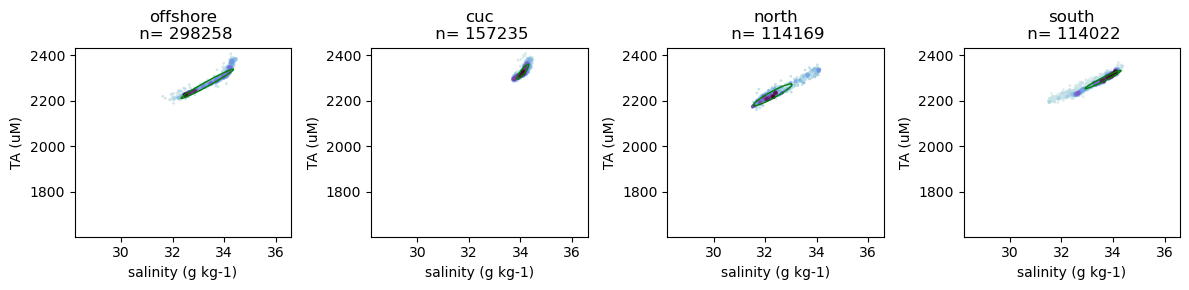

In [8]:
# divisions you're happy with

regions = ['offshore', 'cuc', 'north', 'south']

#elipse information

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','temperature (degC)')
    ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), percentile=75, edgecolor='green',facecolor='none')
    ax[i].add_patch(ellipse)

# show boundaries from CIOPS analysis
ax[1].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[1].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[3].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[3].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

# Nitrate - Salinity
#elipse information

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','NO3 (uM)')
    ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['NO3 (uM)'][sob.region == regions[i]]), percentile=50, edgecolor='green',facecolor='none')
    ax[i].add_patch(ellipse)

plt.tight_layout()

# TA - Salinity
#elipse information

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','TA (uM)')
    ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['TA (uM)'][sob.region == regions[i]]), percentile=50, edgecolor='green',facecolor='none')
    ax[i].add_patch(ellipse)

plt.tight_layout()

In [9]:
# alternative cuc
cuc_l = sob[(sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 50.5) & (sob['salinity (g kg-1)'] >= 33.7-0.2)] # "lighter" version of cuc with lower salinity cuttoff
cuc_h = sob[(sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 50.5) & (sob['salinity (g kg-1)'] >= 33.7+0.2)] # 'heavier" version of cuc with higher salinity cuttoff

# alternative south upper division
south_ul = sob[((sob.location == 'shelf') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5)) | ((sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5) & (sob['salinity (g kg-1)'] < 33.7-0.2))]
south_uh = sob[((sob.location == 'shelf') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5)) | ((sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5) & (sob['salinity (g kg-1)'] < 33.7+0.2))]

# alternative south lower division
south_ll = sob[((sob.location == 'shelf') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5-0.2)) | ((sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5-0.2) & (sob['salinity (g kg-1)'] < 33.7))]
south_lh = sob[((sob.location == 'shelf') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5+0.2)) | ((sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] > 31.5+0.2) & (sob['salinity (g kg-1)'] < 33.7))]

# alternative brackish 
brack_l = sob[sob['salinity (g kg-1)'] <= 31.5-0.2]
brack_h = sob[sob['salinity (g kg-1)'] <= 31.5+0.2]


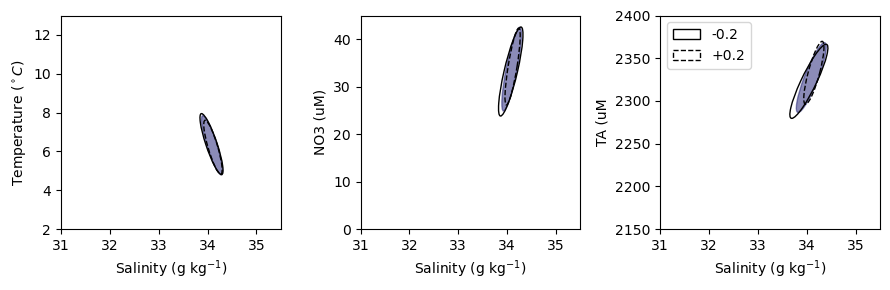

In [10]:
#######
# CUC #
#######
fig, ax = plt.subplots(1,3,figsize=[9,3])

colour = 'midnightblue'
# plot ellipses for different cuttofs
ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'cuc']), np.array(sob['temperature (degC)'][sob.region == 'cuc']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(cuc_l['salinity (g kg-1)']), (cuc_l['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(cuc_h['salinity (g kg-1)']), (cuc_h['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[0].add_patch(ellipse)
ax[0].add_patch(l_ellipse)
ax[0].add_patch(h_ellipse)
ax[0].set_ylim([2,13])
ax[0].set_xlim([31,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'cuc']), np.array(sob['NO3 (uM)'][sob.region == 'cuc']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(cuc_l['salinity (g kg-1)']), (cuc_l['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(cuc_h['salinity (g kg-1)']), (cuc_h['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[1].add_patch(ellipse)
ax[1].add_patch(l_ellipse)
ax[1].add_patch(h_ellipse)
ax[1].set_ylim([0,45])
ax[1].set_xlim([31,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'cuc']), np.array(sob['TA (uM)'][sob.region == 'cuc']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(cuc_l['salinity (g kg-1)']), (cuc_l['TA (uM)']), percentile=75, facecolor='none', edgecolor='k',label='-0.2')
h_ellipse = percentile_ellipse(np.array(cuc_h['salinity (g kg-1)']), (cuc_h['TA (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed',label='+0.2')

ax[2].add_patch(ellipse)
ax[2].add_patch(l_ellipse)
ax[2].add_patch(h_ellipse)
ax[2].legend()
ax[2].set_ylim([2150,2400])
ax[2].set_xlim([31,35.5])
ax[2].set_ylabel('TA (uM')
ax[2].set_xlabel('Salinity (g kg$^{-1}$)')

plt.tight_layout()

In [11]:
# print mean and standard deviation of all properties
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 'Nstar (umol kg-1)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)',
                'DIC (uM)', 'Carbonate','Aragonite', 'Calcite']
data = sob[sob.region == 'cuc']
l_data = cuc_l
h_data = cuc_h

for prop in properties:
    print(prop)
    print("mean = {}, std = {}".format(np.nanmean(data[prop]),np.nanstd(data[prop])))
    print("-0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(l_data[prop]),np.nanstd(l_data[prop]),np.nanmean(l_data[prop])-np.nanmean(data[prop])))
    print("+0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(h_data[prop]),np.nanstd(h_data[prop]),np.nanmean(h_data[prop])-np.nanmean(data[prop])))
    if np.max([abs(np.nanmean(l_data[prop])-np.nanmean(data[prop])),abs(np.nanmean(h_data[prop])-np.nanmean(data[prop]))]) < np.nanstd(data[prop]):
        print("change is LESS than one standard deviation")
    else:
        print("change is MORE than one standard deviation")
    print('\n')
    

temperature (degC)
mean = 6.391148883594853, std = 0.9856776899609078
-0.2 mean = 6.4741803843322945, std = 1.0323314775573178, diff = 0.08303150073744181
+0.2 mean = 6.227271267058993, std = 0.8987769195136437, diff = -0.16387761653585997
change is LESS than one standard deviation


salinity (g kg-1)
mean = 34.077131230443094, std = 0.14585211109022106
-0.2 mean = 34.05004466502764, std = 0.1795319973187753, diff = -0.027086565415451958
+0.2 mean = 34.11124810077722, std = 0.11627271828499193, diff = 0.03411687033412392
change is LESS than one standard deviation


density (kg m-3)
mean = 1027.8541916539127, std = 0.7203193023931691
-0.2 mean = 1027.7812643798013, std = 0.7630195074717806, diff = -0.07292727411140731
+0.2 mean = 1027.9818166459413, std = 0.6591623566325426, diff = 0.12762499202858635
change is LESS than one standard deviation


spice
mean = -0.1040503029571856, std = 0.08083036166977274
-0.2 mean = -0.11105790144970451, std = 0.08926746315022602, diff = -0.007007598492

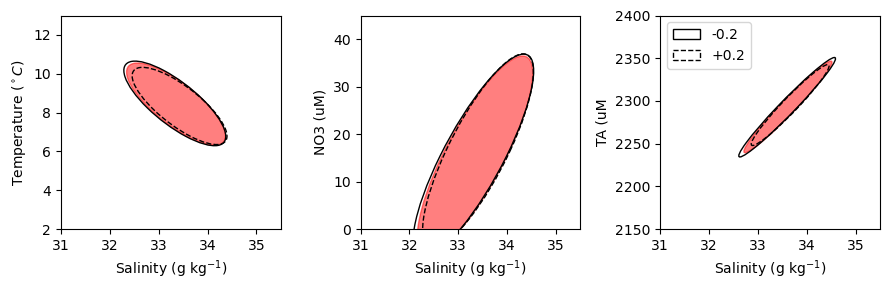

In [12]:
###############
# SOUTH UPPER #
###############
fig, ax = plt.subplots(1,3,figsize=[9,3])

colour = 'red'
# plot ellipses for different cuttofs
ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'south']), np.array(sob['temperature (degC)'][sob.region == 'south']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(south_ul['salinity (g kg-1)']), (south_ul['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(south_uh['salinity (g kg-1)']), (south_uh['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[0].add_patch(ellipse)
ax[0].add_patch(l_ellipse)
ax[0].add_patch(h_ellipse)
ax[0].set_ylim([2,13])
ax[0].set_xlim([31,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'south']), np.array(sob['NO3 (uM)'][sob.region == 'south']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(south_ul['salinity (g kg-1)']), (south_ul['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(south_uh['salinity (g kg-1)']), (south_uh['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[1].add_patch(ellipse)
ax[1].add_patch(l_ellipse)
ax[1].add_patch(h_ellipse)
ax[1].set_ylim([0,45])
ax[1].set_xlim([31,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'south']), np.array(sob['TA (uM)'][sob.region == 'south']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(south_ul['salinity (g kg-1)']), (south_ul['TA (uM)']), percentile=75, facecolor='none', edgecolor='k',label='-0.2')
h_ellipse = percentile_ellipse(np.array(south_uh['salinity (g kg-1)']), (south_uh['TA (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed',label='+0.2')

ax[2].add_patch(ellipse)
ax[2].add_patch(l_ellipse)
ax[2].add_patch(h_ellipse)
ax[2].legend()
ax[2].set_ylim([2150,2400])
ax[2].set_xlim([31,35.5])
ax[2].set_ylabel('TA (uM')
ax[2].set_xlabel('Salinity (g kg$^{-1}$)')

plt.tight_layout()

In [13]:
# print mean and standard deviation of all properties
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 'Nstar (umol kg-1)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)',
                'DIC (uM)', 'Carbonate','Aragonite', 'Calcite']
data = sob[sob.region == 'south']
l_data = south_ul
h_data = south_uh

for prop in properties:
    print(prop)
    print("mean = {}, std = {}".format(np.nanmean(data[prop]),np.nanstd(data[prop])))
    print("-0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(l_data[prop]),np.nanstd(l_data[prop]),np.nanmean(l_data[prop])-np.nanmean(data[prop])))
    print("+0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(h_data[prop]),np.nanstd(h_data[prop]),np.nanmean(h_data[prop])-np.nanmean(data[prop])))
    if np.max([abs(np.nanmean(l_data[prop])-np.nanmean(data[prop])),abs(np.nanmean(h_data[prop])-np.nanmean(data[prop]))]) < np.nanstd(data[prop]):
        print("change is LESS than one standard deviation")
    else:
        print("change is MORE than one standard deviation")
    print('\n')

temperature (degC)
mean = 9.037999826961588, std = 1.8204252108936239
-0.2 mean = 9.07549933472721, std = 1.8414858336713085, diff = 0.03749950776562194
+0.2 mean = 8.93693096825158, std = 1.7851786462389043, diff = -0.1010688587100077
change is LESS than one standard deviation


salinity (g kg-1)
mean = 33.13529651437408, std = 0.6384640069190208
-0.2 mean = 33.11510820824665, std = 0.6441645588788726, diff = -0.020188306127430167
+0.2 mean = 33.19229195480892, std = 0.6400166858442456, diff = 0.056995440434839395
change is LESS than one standard deviation


density (kg m-3)
mean = 1025.7268239442737, std = 0.8390125410446826
-0.2 mean = 1025.6938900471944, std = 0.8395361258108398, diff = -0.03293389707937422
+0.2 mean = 1025.8199747165886, std = 0.8634381578098033, diff = 0.09315077231485702
change is LESS than one standard deviation


spice
mean = -0.3652767684823486, std = 0.34472335172269125
-0.2 mean = -0.37326128367844663, std = 0.3485025791322913, diff = -0.007984515196098052


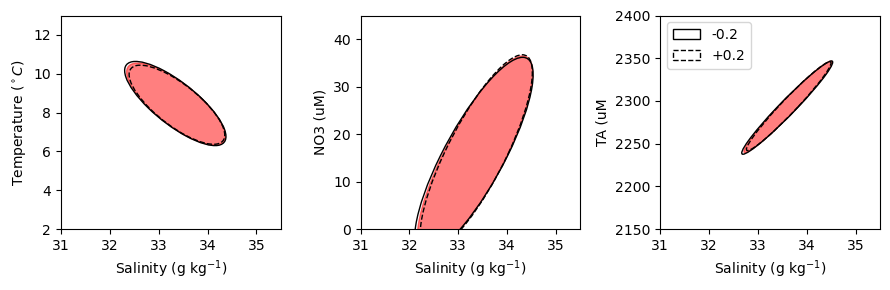

In [14]:
###############
# SOUTH LOWER #
###############
fig, ax = plt.subplots(1,3,figsize=[9,3])

colour = 'red'
# plot ellipses for different cuttofs
ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'south']), np.array(sob['temperature (degC)'][sob.region == 'south']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(south_ll['salinity (g kg-1)']), (south_ll['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(south_lh['salinity (g kg-1)']), (south_lh['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[0].add_patch(ellipse)
ax[0].add_patch(l_ellipse)
ax[0].add_patch(h_ellipse)
ax[0].set_ylim([2,13])
ax[0].set_xlim([31,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'south']), np.array(sob['NO3 (uM)'][sob.region == 'south']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(south_ll['salinity (g kg-1)']), (south_ll['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(south_lh['salinity (g kg-1)']), (south_lh['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[1].add_patch(ellipse)
ax[1].add_patch(l_ellipse)
ax[1].add_patch(h_ellipse)
ax[1].set_ylim([0,45])
ax[1].set_xlim([31,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'south']), np.array(sob['TA (uM)'][sob.region == 'south']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(south_ll['salinity (g kg-1)']), (south_ll['TA (uM)']), percentile=75, facecolor='none', edgecolor='k',label='-0.2')
h_ellipse = percentile_ellipse(np.array(south_lh['salinity (g kg-1)']), (south_lh['TA (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed',label='+0.2')

ax[2].add_patch(ellipse)
ax[2].add_patch(l_ellipse)
ax[2].add_patch(h_ellipse)
ax[2].legend()
ax[2].set_ylim([2150,2400])
ax[2].set_xlim([31,35.5])
ax[2].set_ylabel('TA (uM')
ax[2].set_xlabel('Salinity (g kg$^{-1}$)')

plt.tight_layout()

In [15]:
# print mean and standard deviation of all properties
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 'Nstar (umol kg-1)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)',
                'DIC (uM)', 'Carbonate','Aragonite', 'Calcite']
data = sob[sob.region == 'south']
l_data = south_ll
h_data = south_lh

for prop in properties:
    print(prop)
    print("mean = {}, std = {}".format(np.nanmean(data[prop]),np.nanstd(data[prop])))
    print("-0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(l_data[prop]),np.nanstd(l_data[prop]),np.nanmean(l_data[prop])-np.nanmean(data[prop])))
    print("+0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(h_data[prop]),np.nanstd(h_data[prop]),np.nanmean(h_data[prop])-np.nanmean(data[prop])))
    if np.max([abs(np.nanmean(l_data[prop])-np.nanmean(data[prop])),abs(np.nanmean(h_data[prop])-np.nanmean(data[prop]))]) < np.nanstd(data[prop]):
        print("change is LESS than one standard deviation")
    else:
        print("change is MORE than one standard deviation")
    print('\n')

temperature (degC)
mean = 9.037999826961588, std = 1.8204252108936239
-0.2 mean = 9.093073698271143, std = 1.8748550075244592, diff = 0.055073871309554434
+0.2 mean = 8.970027408937385, std = 1.7556634204661725, diff = -0.06797241802420295
change is LESS than one standard deviation


salinity (g kg-1)
mean = 33.13529651437408, std = 0.6384640069190208
-0.2 mean = 33.11004432505785, std = 0.6670286230536466, diff = -0.025252189316233853
+0.2 mean = 33.165920750375705, std = 0.6066485337431541, diff = 0.03062423600162134
change is LESS than one standard deviation


density (kg m-3)
mean = 1025.7268239442737, std = 0.8390125410446826
-0.2 mean = 1025.6951677777042, std = 0.8736708935046186, diff = -0.03165616656951897
+0.2 mean = 1025.7655109456132, std = 0.7995079589315206, diff = 0.03868700133944003
change is LESS than one standard deviation


spice
mean = -0.3652767684823486, std = 0.34472335172269125
-0.2 mean = -0.37363212243835187, std = 0.35159175403936427, diff = -0.00835535395600

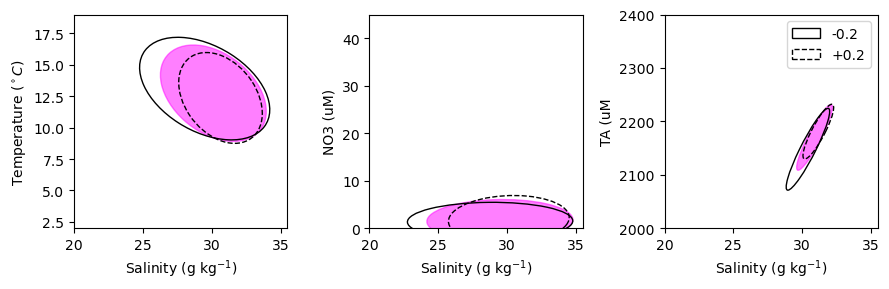

In [16]:
############
# BRACKISH #
############
fig, ax = plt.subplots(1,3,figsize=[9,3])

colour = 'magenta'
# plot ellipses for different cuttofs
ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'brackish']), np.array(sob['temperature (degC)'][sob.region == 'brackish']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(brack_l['salinity (g kg-1)']), (brack_l['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(brack_h['salinity (g kg-1)']), (brack_h['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[0].add_patch(ellipse)
ax[0].add_patch(l_ellipse)
ax[0].add_patch(h_ellipse)
ax[0].set_ylim([2,19])
ax[0].set_xlim([20,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'brackish']), np.array(sob['NO3 (uM)'][sob.region == 'brackish']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(brack_l['salinity (g kg-1)']), (brack_l['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(brack_h['salinity (g kg-1)']), (brack_h['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[1].add_patch(ellipse)
ax[1].add_patch(l_ellipse)
ax[1].add_patch(h_ellipse)
ax[1].set_ylim([0,45])
ax[1].set_xlim([20,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == 'brackish']), np.array(sob['TA (uM)'][sob.region == 'brackish']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(brack_l['salinity (g kg-1)']), (brack_l['TA (uM)']), percentile=75, facecolor='none', edgecolor='k',label='-0.2')
h_ellipse = percentile_ellipse(np.array(brack_h['salinity (g kg-1)']), (brack_h['TA (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed',label='+0.2')

ax[2].add_patch(ellipse)
ax[2].add_patch(l_ellipse)
ax[2].add_patch(h_ellipse)
ax[2].legend()
ax[2].set_ylim([2000,2400])
ax[2].set_xlim([20,35.5])
ax[2].set_ylabel('TA (uM')
ax[2].set_xlabel('Salinity (g kg$^{-1}$)')

plt.tight_layout()

In [17]:
# print mean and standard deviation of all properties
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 'Nstar (umol kg-1)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)',
                'DIC (uM)', 'Carbonate','Aragonite', 'Calcite']
data = sob[sob.region == 'south']
l_data = brack_l
h_data = brack_h

for prop in properties:
    print(prop)
    print("mean = {}, std = {}".format(np.nanmean(data[prop]),np.nanstd(data[prop])))
    print("-0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(l_data[prop]),np.nanstd(l_data[prop]),np.nanmean(l_data[prop])-np.nanmean(data[prop])))
    print("+0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(h_data[prop]),np.nanstd(h_data[prop]),np.nanmean(h_data[prop])-np.nanmean(data[prop])))
    if np.max([abs(np.nanmean(l_data[prop])-np.nanmean(data[prop])),abs(np.nanmean(h_data[prop])-np.nanmean(data[prop]))]) < np.nanstd(data[prop]):
        print("change is LESS than one standard deviation")
    else:
        print("change is MORE than one standard deviation")
    print('\n')

temperature (degC)
mean = 9.037999826961588, std = 1.8204252108936239
-0.2 mean = 13.666518579504718, std = 2.8460086180915773, diff = 4.62851875254313
+0.2 mean = 12.958584805418987, std = 2.717178186253459, diff = 3.9205849784573985
change is MORE than one standard deviation


salinity (g kg-1)
mean = 33.13529651437408, std = 0.6384640069190208
-0.2 mean = 28.164282352340695, std = 4.871818136144426, diff = -4.971014162033388
+0.2 mean = 29.471354706931017, std = 4.146580869504414, diff = -3.6639418074430665
change is MORE than one standard deviation


density (kg m-3)
mean = 1025.7268239442737, std = 0.8390125410446826
-0.2 mean = 1020.8427713409841, std = 3.9881933610348286, diff = -4.8840526032896605
+0.2 mean = 1021.9979010748104, std = 3.471561830212028, diff = -3.728922869463304
change is MORE than one standard deviation


spice
mean = -0.3652767684823486, std = 0.34472335172269125
-0.2 mean = -3.1849263994580217, std = 3.4510225808048998, diff = -2.819649630975673
+0.2 mean = 

In [18]:
# WINTER DIVISIONS

# really just south water important in the winter so i think the results will be less sensitive to N/S spatial divisions
# i'm also less worried about the JdF Eddy, so maybe its ok to take points near the entrance to the salish sea

# CUC = slope water south of 50.5 & salinity greater than or equal to 33.8 (need to do sensitivity analysis on this salinity choice)
# north shelf = shelf water north of 50.5, slope water north of 50.5 in the top 200 m
# south shelf = shelf water south of 50.5, slope water south of 50.5 with salinity less than 33.8
# brackish = salinity less than or equal to 32
# offshore = offshore of 2000 m contour

wob['region'] = 'none'
wob.region[wob.location == 'offshore'] = 'offshore'
wob.region[(wob.location == 'shelf') & (wob['latitude (degrees_north)'] >= 49)] = 'north'
wob.region[(wob.location == 'shelf') & (wob['latitude (degrees_north)'] <= 47.3)] = 'south'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] >= 49) & (wob['depth (m)'] <= 200)] = 'north'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] < 33.7)] = 'south'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 50.5) & (wob['salinity (g kg-1)'] >= 33.7)] = 'cuc'
wob.region[wob['salinity (g kg-1)'] <= 31.5] = 'brackish' # putting this one last will remove the <32 points from the other regions

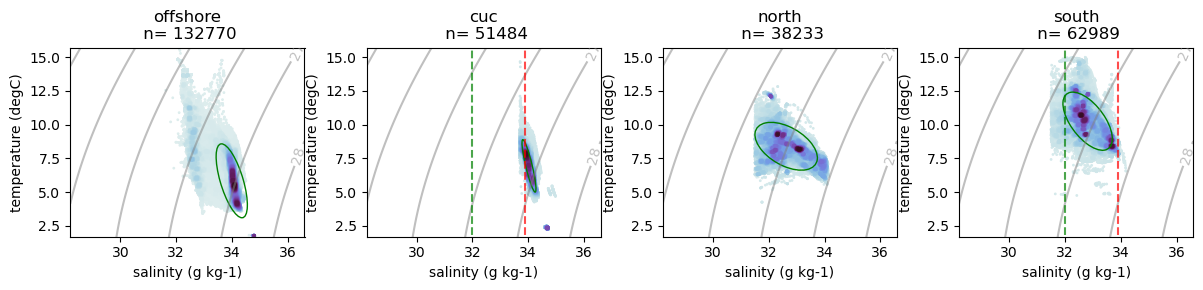

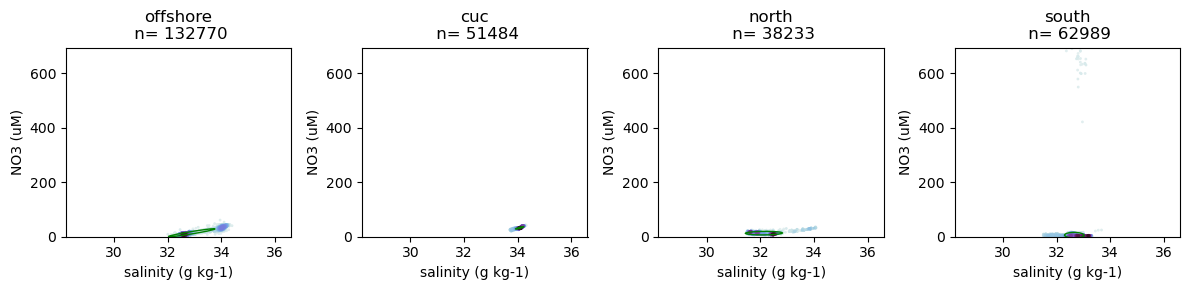

In [19]:
# divisions you're happy with

regions = ['offshore', 'cuc', 'north', 'south']

#elipse information

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(wob,regions[i],ax[i],'salinity (g kg-1)','temperature (degC)')
    ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), percentile=75, edgecolor='green',facecolor='none')
    ax[i].add_patch(ellipse)

# show boundaries from CIOPS analysis
ax[1].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[1].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[3].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[3].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

# Nitrate - Salinity
#elipse information

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(wob,regions[i],ax[i],'salinity (g kg-1)','NO3 (uM)')
    ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['NO3 (uM)'][wob.region == regions[i]]), percentile=50, edgecolor='green',facecolor='none')
    ax[i].add_patch(ellipse)

plt.tight_layout()

In [20]:
# alternative cuc
cuc_l = wob[(wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 50.5) & (wob['salinity (g kg-1)'] >= 33.7-0.2)] # "lighter" version of cuc with lower salinity cuttoff
cuc_h = wob[(wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 50.5) & (wob['salinity (g kg-1)'] >= 33.7+0.2)] # 'heavier" version of cuc with higher salinity cuttoff

# alternative south upper division
south_ul = wob[((wob.location == 'shelf') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] > 31.5)) | ((wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] > 31.5) & (wob['salinity (g kg-1)'] < 33.7-0.2))]
south_uh = wob[((wob.location == 'shelf') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] > 31.5)) | ((wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] > 31.5) & (wob['salinity (g kg-1)'] < 33.7+0.2))]

# alternative south lower division
south_ll = wob[((wob.location == 'shelf') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] > 31.5-0.2)) | ((wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] > 31.5-0.2) & (wob['salinity (g kg-1)'] < 33.7))]
south_lh = wob[((wob.location == 'shelf') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] > 31.5+0.2)) | ((wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] > 31.5+0.2) & (wob['salinity (g kg-1)'] < 33.7))]

# alternative brackish 
brack_l = wob[wob['salinity (g kg-1)'] <= 31.5-0.2]
brack_h = wob[wob['salinity (g kg-1)'] <= 31.5+0.2]



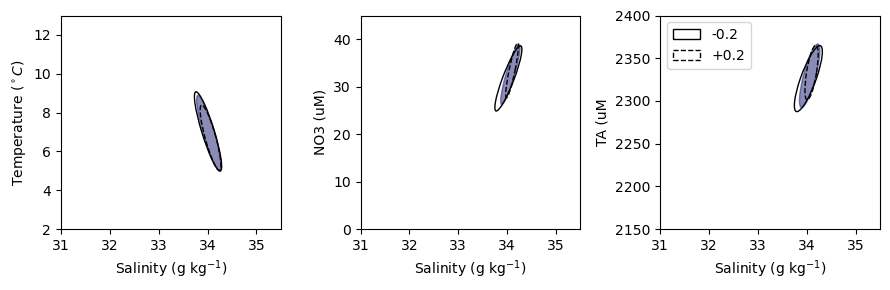

In [21]:
#######
# CUC #
#######
fig, ax = plt.subplots(1,3,figsize=[9,3])

colour = 'midnightblue'
# plot ellipses for different cuttofs
ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == 'cuc']), np.array(wob['temperature (degC)'][wob.region == 'cuc']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(cuc_l['salinity (g kg-1)']), (cuc_l['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(cuc_h['salinity (g kg-1)']), (cuc_h['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[0].add_patch(ellipse)
ax[0].add_patch(l_ellipse)
ax[0].add_patch(h_ellipse)
ax[0].set_ylim([2,13])
ax[0].set_xlim([31,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == 'cuc']), np.array(wob['NO3 (uM)'][wob.region == 'cuc']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(cuc_l['salinity (g kg-1)']), (cuc_l['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(cuc_h['salinity (g kg-1)']), (cuc_h['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[1].add_patch(ellipse)
ax[1].add_patch(l_ellipse)
ax[1].add_patch(h_ellipse)
ax[1].set_ylim([0,45])
ax[1].set_xlim([31,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == 'cuc']), np.array(wob['TA (uM)'][wob.region == 'cuc']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(cuc_l['salinity (g kg-1)']), (cuc_l['TA (uM)']), percentile=75, facecolor='none', edgecolor='k',label='-0.2')
h_ellipse = percentile_ellipse(np.array(cuc_h['salinity (g kg-1)']), (cuc_h['TA (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed',label='+0.2')

ax[2].add_patch(ellipse)
ax[2].add_patch(l_ellipse)
ax[2].add_patch(h_ellipse)
ax[2].legend()
ax[2].set_ylim([2150,2400])
ax[2].set_xlim([31,35.5])
ax[2].set_ylabel('TA (uM')
ax[2].set_xlabel('Salinity (g kg$^{-1}$)')

plt.tight_layout()

In [22]:
# print mean and standard deviation of all properties
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 'Nstar (umol kg-1)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)',
                'DIC (uM)']
data = wob[wob.region == 'cuc']
l_data = cuc_l
h_data = cuc_h

for prop in properties:
    print(prop)
    print("mean = {}, std = {}".format(np.nanmean(data[prop]),np.nanstd(data[prop])))
    print("-0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(l_data[prop]),np.nanstd(l_data[prop]),np.nanmean(l_data[prop])-np.nanmean(data[prop])))
    print("+0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(h_data[prop]),np.nanstd(h_data[prop]),np.nanmean(h_data[prop])-np.nanmean(data[prop])))
    if np.max([abs(np.nanmean(l_data[prop])-np.nanmean(data[prop])),abs(np.nanmean(h_data[prop])-np.nanmean(data[prop]))]) < np.nanstd(data[prop]):
        print("change is LESS than one standard deviation")
    else:
        print("change is MORE than one standard deviation")
    print('\n')

temperature (degC)
mean = 6.888470193635456, std = 1.30578692502139
-0.2 mean = 7.051361725096725, std = 1.3766774429678337, diff = 0.1628915314612689
+0.2 mean = 6.557364901279354, std = 1.2101854903945306, diff = -0.331105292356102
change is LESS than one standard deviation


salinity (g kg-1)
mean = 34.03664717615265, std = 0.1745101514225936
-0.2 mean = 33.9983380631768, std = 0.20709385875191452, diff = -0.038309112975845494
+0.2 mean = 34.08898375821639, std = 0.1497829155788785, diff = 0.05233658206374514
change is LESS than one standard deviation


density (kg m-3)
mean = 1027.7053527857495, std = 0.7139923791449109
-0.2 mean = 1027.6000309833296, std = 0.7677263258018266, diff = -0.10532180241989408
+0.2 mean = 1027.8991530675974, std = 0.6490395749168694, diff = 0.1938002818478708
change is LESS than one standard deviation


spice
mean = -0.05879141543707772, std = 0.10060223354831248
-0.2 mean = -0.06015004159504746, std = 0.10416656284627106, diff = -0.0013586261579697362
+

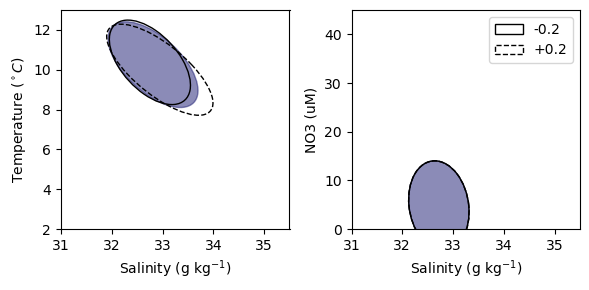

In [23]:
###############
# SOUTH UPPER #
###############
fig, ax = plt.subplots(1,2,figsize=[6,3])

colour = 'midnightblue'
# plot ellipses for different cuttofs
ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == 'south']), np.array(wob['temperature (degC)'][wob.region == 'south']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(south_ul['salinity (g kg-1)']), (south_ul['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(south_uh['salinity (g kg-1)']), (south_uh['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[0].add_patch(ellipse)
ax[0].add_patch(l_ellipse)
ax[0].add_patch(h_ellipse)
ax[0].set_ylim([2,13])
ax[0].set_xlim([31,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == 'south']), np.array(wob['NO3 (uM)'][wob.region == 'south']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(south_ul['salinity (g kg-1)']), (south_ul['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k', label='-0.2')
h_ellipse = percentile_ellipse(np.array(south_uh['salinity (g kg-1)']), (south_uh['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed', label='+0.2')


ax[1].add_patch(ellipse)
ax[1].add_patch(l_ellipse)
ax[1].add_patch(h_ellipse)
ax[1].set_ylim([0,45])
ax[1].set_xlim([31,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')
ax[1].legend()

plt.tight_layout()

In [24]:
# print mean and standard deviation of all properties
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 'Nstar (umol kg-1)','NO3 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)']
data = wob[wob.region == 'south']
l_data = south_ul
h_data = south_uh

for prop in properties:
    print(prop)
    print("mean = {}, std = {}".format(np.nanmean(data[prop]),np.nanstd(data[prop])))
    print("-0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(l_data[prop]),np.nanstd(l_data[prop]),np.nanmean(l_data[prop])-np.nanmean(data[prop])))
    print("+0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(h_data[prop]),np.nanstd(h_data[prop]),np.nanmean(h_data[prop])-np.nanmean(data[prop])))
    if np.max([abs(np.nanmean(l_data[prop])-np.nanmean(data[prop])),abs(np.nanmean(h_data[prop])-np.nanmean(data[prop]))]) < np.nanstd(data[prop]):
        print("change is LESS than one standard deviation")
    else:
        print("change is MORE than one standard deviation")
    print('\n')

temperature (degC)
mean = 10.254884860451412, std = 1.3586198151845488
-0.2 mean = 10.33418269125978, std = 1.3423018643633857, diff = 0.07929783080836827
+0.2 mean = 10.070371821599995, std = 1.4153688552686323, diff = -0.18451303885141712
change is LESS than one standard deviation


salinity (g kg-1)
mean = 32.7988030985087, std = 0.5235527396960032
-0.2 mean = 32.75271586621214, std = 0.4999060430597152, diff = -0.04608723229655709
+0.2 mean = 32.90042325748325, std = 0.5830434561806591, diff = 0.10162015897454779
change is LESS than one standard deviation


density (kg m-3)
mean = 1025.2716495112484, std = 0.692608055360988
-0.2 mean = 1025.20504411253, std = 0.6490307734755306, diff = -0.0666053987183659
+0.2 mean = 1025.4339802302109, std = 0.8209905217601148, diff = 0.16233071896249385
change is LESS than one standard deviation


spice
mean = -0.40572012265562407, std = 0.33526870301525463
-0.2 mean = -0.4262185713424202, std = 0.331643827054886, diff = -0.020498448686796122
+0.

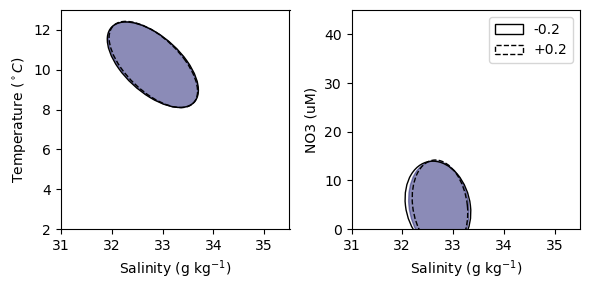

In [25]:
###############
# SOUTH LOWER #
###############
fig, ax = plt.subplots(1,2,figsize=[6,3])

colour = 'midnightblue'
# plot ellipses for different cuttofs
ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == 'south']), np.array(wob['temperature (degC)'][wob.region == 'south']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(south_ll['salinity (g kg-1)']), (south_ll['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(south_lh['salinity (g kg-1)']), (south_lh['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[0].add_patch(ellipse)
ax[0].add_patch(l_ellipse)
ax[0].add_patch(h_ellipse)
ax[0].set_ylim([2,13])
ax[0].set_xlim([31,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == 'south']), np.array(wob['NO3 (uM)'][wob.region == 'south']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(south_ll['salinity (g kg-1)']), (south_ll['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k', label='-0.2')
h_ellipse = percentile_ellipse(np.array(south_lh['salinity (g kg-1)']), (south_lh['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed', label='+0.2')


ax[1].add_patch(ellipse)
ax[1].add_patch(l_ellipse)
ax[1].add_patch(h_ellipse)
ax[1].set_ylim([0,45])
ax[1].set_xlim([31,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')
ax[1].legend()

plt.tight_layout()

In [26]:
# print mean and standard deviation of all properties
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 'Nstar (umol kg-1)','NO3 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)']
data = wob[wob.region == 'south']
l_data = south_ll
h_data = south_lh

for prop in properties:
    print(prop)
    print("mean = {}, std = {}".format(np.nanmean(data[prop]),np.nanstd(data[prop])))
    print("-0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(l_data[prop]),np.nanstd(l_data[prop]),np.nanmean(l_data[prop])-np.nanmean(data[prop])))
    print("+0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(h_data[prop]),np.nanstd(h_data[prop]),np.nanmean(h_data[prop])-np.nanmean(data[prop])))
    if np.max([abs(np.nanmean(l_data[prop])-np.nanmean(data[prop])),abs(np.nanmean(h_data[prop])-np.nanmean(data[prop]))]) < np.nanstd(data[prop]):
        print("change is LESS than one standard deviation")
    else:
        print("change is MORE than one standard deviation")
    print('\n')

temperature (degC)
mean = 10.254884860451412, std = 1.3586198151845488
-0.2 mean = 10.261951572371368, std = 1.352007404167231, diff = 0.0070667119199558925
+0.2 mean = 10.259460689061886, std = 1.356396570104321, diff = 0.004575828610473565
change is LESS than one standard deviation


salinity (g kg-1)
mean = 32.7988030985087, std = 0.5235527396960032
-0.2 mean = 32.78290594615167, std = 0.5412575636718463, diff = -0.015897152357027267
+0.2 mean = 32.818480782784576, std = 0.5047051838025451, diff = 0.019677684275876572
change is LESS than one standard deviation


density (kg m-3)
mean = 1025.2716495112484, std = 0.692608055360988
-0.2 mean = 1025.2570470767366, std = 0.7023489887639119, diff = -0.014602434511743922
+0.2 mean = 1025.2899431211208, std = 0.6829232060811631, diff = 0.018293609872443994
change is LESS than one standard deviation


spice
mean = -0.40572012265562407, std = 0.33526870301525463
-0.2 mean = -0.4170301267280706, std = 0.35036851871667074, diff = -0.01131000407

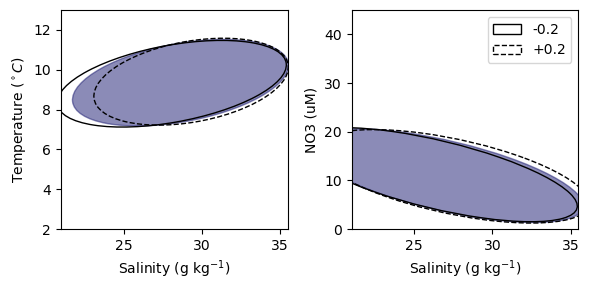

In [27]:
###############
# SOUTH LOWER #
###############
fig, ax = plt.subplots(1,2,figsize=[6,3])

colour = 'midnightblue'
# plot ellipses for different cuttofs
ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == 'brackish']), np.array(wob['temperature (degC)'][wob.region == 'brackish']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(brack_l['salinity (g kg-1)']), (brack_l['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k')
h_ellipse = percentile_ellipse(np.array(brack_h['salinity (g kg-1)']), (brack_h['temperature (degC)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed')


ax[0].add_patch(ellipse)
ax[0].add_patch(l_ellipse)
ax[0].add_patch(h_ellipse)
ax[0].set_ylim([2,13])
ax[0].set_xlim([21,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')

ellipse = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == 'brackish']), np.array(wob['NO3 (uM)'][wob.region == 'brackish']), percentile=75, facecolor=colour, edgecolor=colour,alpha=0.5)
l_ellipse = percentile_ellipse(np.array(brack_l['salinity (g kg-1)']), (brack_l['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k', label='-0.2')
h_ellipse = percentile_ellipse(np.array(brack_h['salinity (g kg-1)']), (brack_h['NO3 (uM)']), percentile=75, facecolor='none', edgecolor='k',ls='dashed', label='+0.2')


ax[1].add_patch(ellipse)
ax[1].add_patch(l_ellipse)
ax[1].add_patch(h_ellipse)
ax[1].set_ylim([0,45])
ax[1].set_xlim([21,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')
ax[1].legend()

plt.tight_layout()

In [28]:
# print mean and standard deviation of all properties
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 'Nstar (umol kg-1)','NO3 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)']
data = wob[wob.region == 'brackish']
l_data = brack_l
h_data = brack_h

for prop in properties:
    print(prop)
    print("mean = {}, std = {}".format(np.nanmean(data[prop]),np.nanstd(data[prop])))
    print("-0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(l_data[prop]),np.nanstd(l_data[prop]),np.nanmean(l_data[prop])-np.nanmean(data[prop])))
    print("+0.2 mean = {}, std = {}, diff = {}".format(np.nanmean(h_data[prop]),np.nanstd(h_data[prop]),np.nanmean(h_data[prop])-np.nanmean(data[prop])))
    if np.max([abs(np.nanmean(l_data[prop])-np.nanmean(data[prop])),abs(np.nanmean(h_data[prop])-np.nanmean(data[prop]))]) < np.nanstd(data[prop]):
        print("change is LESS than one standard deviation")
    else:
        print("change is MORE than one standard deviation")
    print('\n')

temperature (degC)
mean = 9.265954311745357, std = 1.5500196038374958
-0.2 mean = 9.216670425342906, std = 1.5581171825802829, diff = -0.04928388640245096
+0.2 mean = 9.278407086264279, std = 1.5477676403546499, diff = 0.012452774518921572
change is LESS than one standard deviation


salinity (g kg-1)
mean = 27.445955062423085, std = 5.749553856297324
-0.2 mean = 26.8126527422424, std = 5.952505251509035, diff = -0.633302320180686
+0.2 mean = 28.167595383240513, std = 5.459550913715764, diff = 0.7216403208174285
change is LESS than one standard deviation


density (kg m-3)
mean = 1020.8556728954217, std = 4.552246891613734
-0.2 mean = 1020.3902909263954, std = 4.673220323238585, diff = -0.4653819690262253
+0.2 mean = 1021.411236081957, std = 4.376684994552627, diff = 0.5555631865353234
change is LESS than one standard deviation


spice
mean = -4.672485683111769, std = 4.359099209773426
-0.2 mean = -5.112141699563083, std = 4.480019823104038, diff = -0.43965601645131436
+0.2 mean = -4.1